In [1]:
###################################################################################################
# Define parameters and query data
###################################################################################################

# Use this to read in packages from other directories ---------
import sys, os
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd()))) # two dirs back
#--------------------------------------------------------------
from ClimateDataVisualizer.dataquery import NOAA_ACIS_stndata as stndata

variable = 'pcpn' # Rain (Daily Rainfall)

# Location and bounding box
location_name = 'St. Louis, MO'
nlat = 38.8     # northern latitude
slat = 38.6     # southern latitude
wlon = -90.4   # western longitude
elon = -90.2   # eastern longitude

# Query variable
var, meta = stndata.bbox_multistn_daily(elem=variable,slat=slat,nlat=nlat,wlon=wlon,elon=elon,
                                        print_md=False)

pcpn: Reading in 18 total stations (station id: name, state) ...
#1. 237452: ST LOUIS SCIENCE CENTER, MO
#2. 237465: ST LOUIS ST LOUIS UNIV, MO
#3. 237470: SAINT LOUIS WASHINGTON UNIV, MO
#4. 238525: UNIVERSITY CITY, MO
#5. US1MOSL0020: LADUE 1.6 N, MO
#6. US1MOSLC004: ST. LOUIS 1.5 S, MO
#7. US1MOSLC005: ST. LOUIS 2.4 S, MO
#8. US1MOSL0035: ST. LOUIS 1.0 SW, MO
#9. US1MOSL0050: WEBSTER GROVES 1.6 NNE, MO
#10. US1MOSL0061: WARSON WOODS 0.2 E, MO
#11. US1MOSL0081: CLAYTON 1.2 NW, MO
#12. 237462: SAINT LOUIS 12 NNW, MO
#13. 13994: ST LOUIS LAMBERT INTL AIRPORT, MO
#14. 93910: ST LOUIS LAMBERT, MO
#15. US1MOSL0039: FLORISSANT 1.3 E, MO
#16. US1MOFSA189: EDMUNDSON 0.7 NNW, MO
#17. US1MOSL0024: FLORISSANT 2.9 W, MO
#18. US1MOSL0064: ST. ANN 0.6 S, MO


In [56]:
# PLOT

# Use this to read in packages from other directories ---------
import sys, os 
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd()))) # two dirs back
#--------------------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cartopy, cartopy.mpl.geoaxes, cartopy.io.img_tiles
import xarray as xr
import urllib, json
import geocat.viz.util as gv
import cmaps
import math
from ClimateDataVisualizer.dataquery import NOAA_ACIS_stnmeta as stnmeta
from ClimateDataVisualizer.dataquery import NOAA_ACIS_stndata as stndata
from ClimateDataVisualizer.processing.bbox_dy import bbox_avg_dy
from ClimateDataVisualizer.processing.bbox_my import bbox_avg_my, bbox_max_my, bbox_min_my
from ClimateDataVisualizer.inset_axes.inset_axes import inset_map, inset_timeseries
import warnings

def spatialmap_pcpn_plot(var,meta,location_name,nlat,slat,wlon,elon,timespan,stats,incl_loc,stns_col,
                         dot_size,cmap,incl_ticks,nlatbuf,slatbuf,wlonbuf,elonbuf,latstride,lonstride,
                         # Lots of ways to input date range, if none specified then error message will appear
                         sdate=None,edate=None,      # straightforward starting and ending date
                         sngl_md=None,sngl_yr=None,  # single day query in parts for ipyw
                         mult_md1=None,mult_yr1=None,mult_md2=None,mult_yr2=None # multi day query in parts
                         ):
    
    ############################################################################################################# 
    # Perform json request for griddata
    ############################################################################################################# 
    
    # Determine input date range - this pieces together input parameters specified when calling function
    if timespan == 'Single Day':
        if sdate is not None:
            sdate, edate = sdate, sdate # set sdate and edate as same
        elif sngl_md is not None and sngl_yr is not None:
            sdate = str(sngl_yr)+'-'+str(sngl_md)
            edate = sdate
    if timespan == 'Multiple Days':
        if sdate is not None and edate is not None:
            sdate, edate = sdate, edate # pass sdate and edate through
        elif mult_md1 is not None and mult_yr1 is not None and mult_md2 is not None and mult_yr2 is not None:
            sdate, edate = str(mult_yr1)+'-'+str(mult_md1), str(mult_yr2)+'-'+str(mult_md2)
    
    # Perform json request
    print(sdate,edate)
    print(type(sdate),type(edate))
    try: 
        params = {'bbox':[wlon-wlonbuf,slat-slatbuf,elon+elonbuf,nlat+nlatbuf],'sdate':sdate,'edate':edate,
                  'grid':'1','elems':[{'name':variable}],'meta':'ll'} 
        json_response = urllib.request.urlopen(urllib.request.Request('http://data.rcc-acis.org/GridData',
                                urllib.parse.urlencode({'params':json.dumps(params)}).encode('utf-8'),
                                                       {'Accept':'application/json'})).read()
    except:
        print('Error in choosing date range to query. Check "timespan" and date range input parameters.')
    raw = json.loads(json_response)

    ############################################################################################################# 
    # Process griddata
    ############################################################################################################# 
    
    # Variables (regardless of time length)
    lats  = np.unique(np.array(raw['meta']['lat']).flatten())
    lons  = np.unique(np.array(raw['meta']['lon']).flatten())

    # Process based on length of days queried
    if timespan == 'Single Day':
        # Only one day is queried
        griddata = xr.DataArray(np.array(raw['data'][0][1]).flatten().reshape((len(lats),len(lons))),
                                dims=['lat','lon'],coords=dict(lat=lats,lon=lons))
    elif timespan == 'Multiple Days':
        # More than one day is queried
        date_str = list(dict(raw['data']).keys())                          # finds unique dates as strings
        times = pd.date_range(start=date_str[0],end=date_str[-1],freq='D') # converts strings to datetime64[ns]
        datatime = xr.DataArray(None,dims=['time','lat','lon'],coords=dict(time=times,lat=lats,lon=lons)
                                ).astype(float)
        for d in range(len(times)): # loops through each queried day
            datatime[d,:,:] = np.array(raw['data'][d][1]).flatten().reshape((len(lats),len(lons)))
        # Stats for multiple days
        if stats == 'Mean':
            griddata = datatime.mean(dim='time')
        elif stats == 'Sum':
            griddata = datatime.sum(dim='time')

    # Set missing values and negative values to NaN 
    griddata = griddata.where(griddata != -999, np.nan)
    
    ############################################################################################################# 
    # Define figure and color bars
    ############################################################################################################# 
    
    # Define figure 
    projection = cartopy.crs.PlateCarree() # can try to add more projections later
    fig, ax = plt.subplots(figsize=(8,8),dpi=300,subplot_kw={'projection':projection})
    
    # Define color bar (must unregister before registering)
    white_color = np.array([1.0, 1.0, 1.0, 1.0])  # RGBA values for white
    if cmap == 'Haxby':
        mpl.colormaps.unregister('cmp_haxby_r')
        colorp = cmaps.cmp_haxby_r
    if cmap == 'Blues':
        mpl.colormaps.unregister('MPL_Blues')
        MPL_Blues = cmaps.MPL_Blues(np.arange(10,129)) # 128 total colors
        colorp = mpl.colors.LinearSegmentedColormap.from_list('name', np.vstack([white_color,MPL_Blues]))
    if cmap == 'GreenBlue':
        mpl.colormaps.unregister('MPL_GnBu')
        MPL_GnBu = cmaps.MPL_GnBu(np.arange(30,128)) # 128 total colors
        colorp = mpl.colors.LinearSegmentedColormap.from_list('name', np.vstack([white_color,MPL_GnBu]))

    #############################################################################################################   
    # Plotting contours 
    #############################################################################################################       
    
    # Determine colorbar spacing values
    minval, maxval = 0., math.ceil(0.8*griddata.max())  # colorbar: 0 to 80% of max value
    tksp = 0.5 if maxval <= 5. else (1. if maxval <= 15 else 5.) # colorbar ticks 
    sp50 = (maxval-minval) / 50 # unscaled colobar spacing value
    # Algorithm for keeping colorbar spacing value within confines of ticks
    if len(str(sp50)[str(sp50).index('.') + 1:]) > 1:
        z,y = str(sp50)[-1], str(sp50)[-2]
        add = 0 if int(z) < 5 else 1
        newy = str(int(str(sp50)[-2])+add) 
        spval = float(str(str(sp50)[0:-2])+str(newy)+'0')    
    else: spval = sp50
    if spval <= 0.: spval = 0.1 # spval cannot be zero or negative
    
    # Make contour plot
    cntr = griddata.plot.contourf(ax=ax,transform=projection,add_colorbar=False,add_labels=False,extend='max',
                                  cmap=colorp,levels=np.arange(minval,maxval+spval,spval))

    # Plotting color bar
    cbar_pad = 0.07 if incl_ticks == True else 0.02
    cbar = fig.colorbar(cntr,ax=ax,orientation='horizontal',shrink=0.7,ticks=mpl.ticker.MultipleLocator(tksp),
                        pad=cbar_pad,label='inches',extend='max',spacing='proportional')
    
    # Specifications for map 
    ax.set_extent([wlon-wlonbuf,elon+elonbuf,slat-slatbuf,nlat+nlatbuf])
    ax.add_feature(cartopy.feature.STATES,linewidths=0.5)
    ax.add_feature(cartopy.feature.COASTLINE,linewidths=0.5)
    ax.add_patch(mpl.patches.Rectangle((wlon,slat),abs(wlon)-abs(elon),abs(nlat)-abs(slat),linestyle='-',
                                       facecolor='none',edgecolor='k',linewidth=1,zorder=100))

    #############################################################################################################   
    # Plotting stations 
    #############################################################################################################   

    if incl_loc == True:
        ax.scatter(meta['lon'],meta['lat'],c=stns_col,s=dot_size,zorder=100)
        # Figuring this out later -------------------------------------------------------------------------------
        #if stns_col == 'Colored by value':
        #    # Find values from var
        #    #sdate, edate = '2022-07-26','2022-07-28'
        #    #print(var.loc[var['Date'].between(pd.to_datetime(sdate),pd.to_datetime(edate))])
        #    if timespan == 'Single Day':
        #        stn_vals = var.iloc[:,1:].loc[var['Date'] == pd.to_datetime(sdate)].values.flatten()
        #    ax.scatter(meta['lon'],meta['lat'],c=stn_vals,cmap=colorp,s=dot_size,edgecolors='k',lw=0.5)
        # Figuring this out later -------------------------------------------------------------------------------
    
    #############################################################################################################   
    # Sets map ticks and labels 
    #############################################################################################################   

    if incl_ticks == True:
        gv.set_axes_limits_and_ticks(ax,xlim=(wlon-wlonbuf,elon+elonbuf),ylim=(slat-slatbuf,nlat+nlatbuf),
                                     xticks=np.linspace(-180.,180.,int((360/lonstride)+1)),
                                     yticks=np.linspace(-90.,90.,int((180/latstride)+1)),
                                     xticklabels=[],yticklabels=[])
        gv.add_major_minor_ticks(ax,x_minor_per_major=2,y_minor_per_major=2)
        ax.tick_params(which='major',length=4)
        ax.tick_params(which='minor',length=2)
        gl = ax.gridlines(crs=projection,draw_labels=True,alpha=0.0,color=None,
                          xlim=(wlon-wlonbuf,elon+elonbuf),ylim=(slat-slatbuf,nlat+nlatbuf))
        gl.xlocator = mpl.ticker.MultipleLocator(lonstride)
        gl.ylocator = mpl.ticker.MultipleLocator(latstride)
        gl.top_labels = False
        gl.bottom_labels = True
        gl.left_labels = True
        gl.right_labels = False
        gl.xpadding = 10
        gl.ypadding = 10
        gl.xlabel_style = {'size': 12}
        gl.ylabel_style = {'size': 12}

    #############################################################################################################   
    # Title 
    #############################################################################################################   

    titletxt = stats+' of 24-hr rainfall from '+sdate+' to '+edate if timespan == 'Multiple Days' else \
               '24-hr rainfall on '+sdate
    ax.set_title(titletxt,pad=10,fontsize=12)

# # Run function
# spatialmap_pcpn_plot(var=var,meta=meta,location_name=location_name,nlat=nlat,slat=slat,wlon=wlon,elon=elon,
#                      timespan='Single Day',sdate='2022-07-26',stats='Sum',
#                      incl_loc=True,stns_col='Black',dot_size=5,cmap='GreenBlue',incl_ticks=True,
#                      nlatbuf=5,slatbuf=5,wlonbuf=5.,elonbuf=5.,latstride=0.5,lonstride=0.5)


2023-01-01 2023-01-01
<class 'str'> <class 'str'>


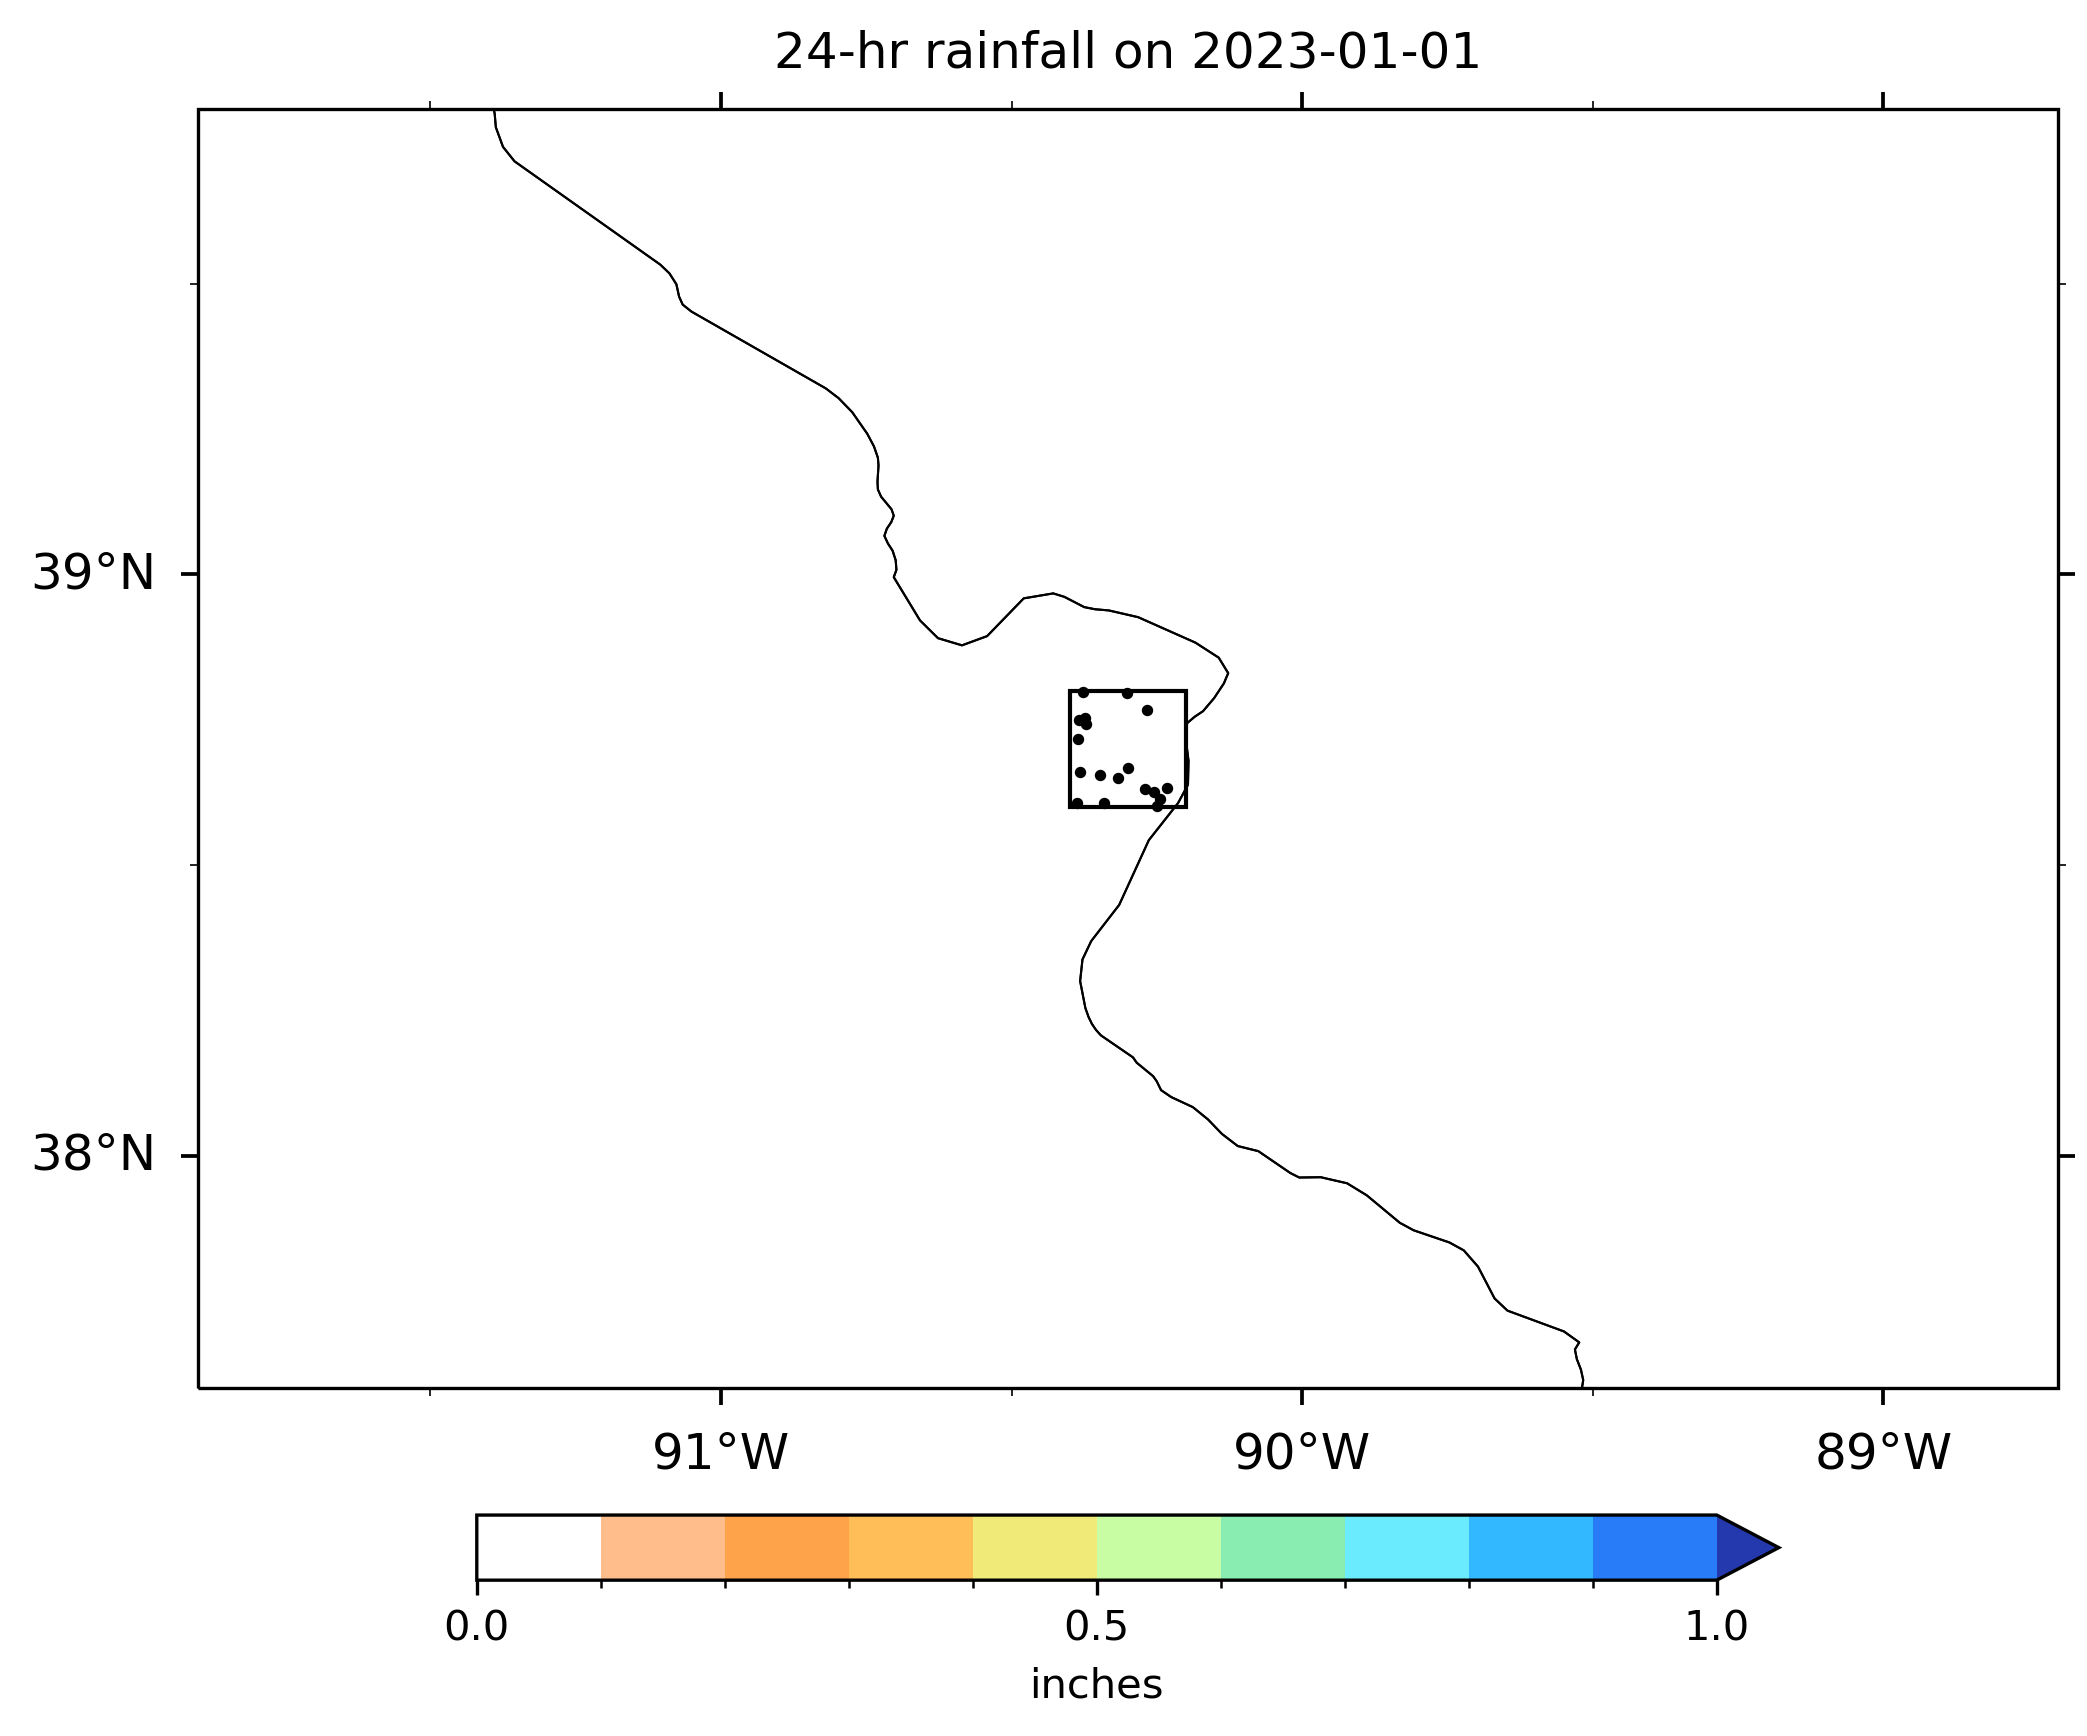

In [57]:
# WIDGET

# Use this to read in packages from other directories ---------
import sys, os
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd()))) # two dirs back
#--------------------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cartopy, cartopy.mpl.geoaxes, cartopy.io.img_tiles
from datetime import datetime
from ClimateDataVisualizer.dataquery import NOAA_ACIS_stnmeta as stnmeta
from ClimateDataVisualizer.dataquery import NOAA_ACIS_stndata as stndata
from ClimateDataVisualizer.processing.bbox_dy import bbox_avg_dy
from ClimateDataVisualizer.inset_axes.inset_axes import inset_map, inset_timeseries
from ClimateDataVisualizer.interactives import plots
from ClimateDataVisualizer.downloads.file_options import pdf_opts, xcl_opts         
import ipywidgets as ipyw
from IPython.display import display, HTML, clear_output

# URLs to use for user help guides, needs double quotes
url_annualcycle = "https://sites.google.com/view/ajtclimate/climate-data-viz/help-annual-cycle"
url_timeseries  = "https://sites.google.com/view/ajtclimate/climate-data-viz/help-time-series"
url_cumulative  = "https://sites.google.com/view/ajtclimate/climate-data-viz/help-cumulative"
url_spatialmap  = "https://sites.google.com/view/ajtclimate/climate-data-viz/help-spatial-map"
url_map         = "https://sites.google.com/view/ajtclimate/climate-data-viz/help-map-of-stations"
url_yaxis       = "https://sites.google.com/view/ajtclimate/climate-data-viz/help-y-axis"

def spatialmap_pcpn_widget(var,meta,location_name,nlat,slat,wlon,elon):
    
    #----------------------------------------------------------------------------------------------
    # Set up parameters to toggle
    #----------------------------------------------------------------------------------------------

    # Variables to define before setting ipywidget variables
    mon_str        = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    days_per_month = [31,29,31,30,31,30,31,31,30,31,30,31]
    tuple_str = [f'{m} {d}' for m,d in zip(np.repeat(mon_str,days_per_month),
                                           np.concatenate([np.arange(1,z+1) for z in days_per_month]))]
    tuple_num = [f'{str(m).zfill(2)}-{str(d).zfill(2)}' for m,d in zip(np.repeat(np.arange(1,13),
                        days_per_month),np.concatenate([np.arange(1,z+1) for z in days_per_month]))] 

    # Date(s) to plot
    txt_date = ipyw.HTML(value=f'<h3><a style="color: black; "href={url_spatialmap} target="_blank" ' +
                                'onmouseover="this.style.textDecoration=\'underline\'" '+
                                'onmouseout="this.style.textDecoration=\'none\'"'+
                                '>Date(s) to plot</a></h3>')
    text_span = ipyw.Label(value='Time Span',layout=ipyw.Layout(width='70px'))
    timespan  = ipyw.Dropdown(options=['Single Day','Multiple Days'],value='Single Day',
                              layout=ipyw.Layout(width='120px'))
    text_sngl = ipyw.Label(value='If single day',layout=ipyw.Layout(width='80px'))
    sngl_md   = ipyw.Dropdown(options=list(zip(tuple_str,tuple_num)),value='01-01',
                              layout=ipyw.Layout(width='75px'))
    sngl_yr   = ipyw.Dropdown(options=np.arange(1950,datetime.now().year+1)[::-1],value=2023,
                              layout=ipyw.Layout(width='70px'))
    text_mult = ipyw.Label(value='If multiple days',layout=ipyw.Layout(width='90px'))
    text_to   = ipyw.Label(value='to',layout=ipyw.Layout(width='20px'))
    mult_md1  = ipyw.Dropdown(options=list(zip(tuple_str,tuple_num)),value='01-01',
                              layout=ipyw.Layout(width='75px'))
    mult_yr1  = ipyw.Dropdown(options=np.arange(1950,datetime.now().year+1)[::-1],value=2023,
                              layout=ipyw.Layout(width='70px'))
    mult_md2  = ipyw.Dropdown(options=list(zip(tuple_str,tuple_num)),value='01-02',
                              layout=ipyw.Layout(width='75px'))
    mult_yr2  = ipyw.Dropdown(options=np.arange(1950,datetime.now().year+1)[::-1],value=2023,
                              layout=ipyw.Layout(width='70px'))
    text_stats = ipyw.Label(value='Stats (if multiple days)',layout=ipyw.Layout(width='140px'))
    stats      = ipyw.Dropdown(options=['Mean','Sum'],value='Sum',layout=ipyw.Layout(width='80px'))
    
    # Display stations
    txt_stns = ipyw.HTML(value=f'<h3><a style="color: black; "href={url_spatialmap} target="_blank" ' +
                                'onmouseover="this.style.textDecoration=\'underline\'" '+
                                'onmouseout="this.style.textDecoration=\'none\'"'+
                                '>Display stations</a></h3>')
    text_loc = ipyw.Label(value='Show locations on map',layout=ipyw.Layout(width='140px'))
    incl_loc = ipyw.Dropdown(options=[True,False],value=True,layout=ipyw.Layout(width='80px'))
    text_col = ipyw.Label(value='Colors of stations',layout=ipyw.Layout(width='140px'))
    stns_col = ipyw.Dropdown(options=[('Black','k'),('Red','r'),('White','w')],# will add colored by value later
                             value='k',layout=ipyw.Layout(width='80px'))
    text_dots = ipyw.Label(value='Station dot size',layout=ipyw.Layout(width='100px'))
    dot_size  = ipyw.IntSlider(value=3,min=1,max=10,step=1,orientation='horizontal',
                               layout=ipyw.Layout(width='140px'))

    # Map extent
    txt_coord = ipyw.HTML(value=f'<h3><a style="color: black; "href={url_spatialmap} target="_blank" ' +
                                'onmouseover="this.style.textDecoration=\'underline\'" '+
                                'onmouseout="this.style.textDecoration=\'none\'"'+
                                '>Map extent</a></h3>')
    text_dist = ipyw.Label(value='Distance from query region',layout=ipyw.Layout(width='160px'))
    text_n    = ipyw.Label(value='North',layout=ipyw.Layout(width='40px'))
    text_s    = ipyw.Label(value='South',layout=ipyw.Layout(width='40px'))
    text_w    = ipyw.Label(value='West',layout=ipyw.Layout(width='40px'))
    text_e    = ipyw.Label(value='East',layout=ipyw.Layout(width='40px'))
    text_deg  = ipyw.Label(value='°',layout=ipyw.Layout(width='10px'))
    nlatbuf   = ipyw.FloatText(value=1.,layout=ipyw.Layout(width='50px'))
    slatbuf   = ipyw.FloatText(value=1.,layout=ipyw.Layout(width='50px'))
    wlonbuf   = ipyw.FloatText(value=1.5,layout=ipyw.Layout(width='50px'))
    elonbuf   = ipyw.FloatText(value=1.5,layout=ipyw.Layout(width='50px'))    

    # Map Properties
    txt_map = ipyw.HTML(value=f'<h3><a style="color: black; "href={url_spatialmap} target="_blank" ' +
                                'onmouseover="this.style.textDecoration=\'underline\'" '+
                                'onmouseout="this.style.textDecoration=\'none\'"'+
                                '>Map properties</a></h3>')
    text_cmap = ipyw.Label(value='Color Map',layout=ipyw.Layout(width='120px'))
    cmap      = ipyw.Dropdown(options=['Haxby','Blues','GreenBlue'],value='Haxby',
                              layout=ipyw.Layout(width='100px'))
    text_ticks = ipyw.Label(value='Show tick marks',layout=ipyw.Layout(width='120px'))
    incl_ticks = ipyw.Dropdown(options=[True,False],value=True,layout=ipyw.Layout(width='100px'))    
    text_stride = ipyw.Label(value='Tick stride',layout=ipyw.Layout(width='70px'))
    text_dlat   = ipyw.Label(value='° lat',layout=ipyw.Layout(width='30px'))
    text_dlon   = ipyw.Label(value='° lon',layout=ipyw.Layout(width='30px'))
    latstride   = ipyw.FloatText(value=1.,layout=ipyw.Layout(width='50px'))
    lonstride   = ipyw.FloatText(value=1.,layout=ipyw.Layout(width='50px'))  
    
    #----------------------------------------------------------------------------------------------
    # Button to update figure
    #----------------------------------------------------------------------------------------------
    
    # Create button
    update_button = ipyw.Button(description='Update Figure',layout=ipyw.Layout(width='150px'))
    
    # Define function that is run when button is clicked
    def update_fig(button):
        
        # Clear figure output and redisplay ipywidgets
        clear_output(wait=True)
        display(ui)             # ui is defined below
        
        # Print message to users
        if timespan.value == 'Multiple Days':
            print('Data is being retrieved! This process may take several minutes if query is large!')
        
        # Run figure again
        spatialmap_pcpn_plot(var=var,meta=meta,location_name=location_name,nlat=float(nlat),
                             slat=float(slat),wlon=float(wlon),elon=float(elon),
                             timespan=timespan.value,sngl_md=sngl_md.value,sngl_yr=sngl_yr.value,
                             mult_md1=mult_md1.value,mult_yr1=mult_yr1.value,
                             mult_md2=mult_md2.value,mult_yr2=mult_yr2.value,stats=stats.value,
                             incl_loc=incl_loc.value,stns_col=stns_col.value,
                             dot_size=dot_size.value,cmap=cmap.value,incl_ticks=incl_ticks.value,
                             nlatbuf=nlatbuf.value,slatbuf=slatbuf.value,wlonbuf=wlonbuf.value,
                             elonbuf=elonbuf.value,latstride=latstride.value,
                             lonstride=lonstride.value)
        
    # On click
    update_button.on_click(update_fig)
    
    #----------------------------------------------------------------------------------------------
    # Layout for dropdowns
    #----------------------------------------------------------------------------------------------

    ui = ipyw.VBox([
                    # FIRST ROW
                    ipyw.HBox([ipyw.VBox([
                                 # Date(s) to plot
                                 ipyw.HBox([txt_date],layout=ipyw.Layout(justify_content='center')),
                                 ipyw.HBox([text_span,timespan],layout=ipyw.Layout(
                                                                        justify_content='center')),
                                 ipyw.HBox([text_sngl,sngl_md,sngl_yr],
                                           layout=ipyw.Layout(justify_content='center')),
                                 ipyw.HBox([text_mult,mult_md1,mult_yr1,text_to,mult_md2,mult_yr2],
                                           layout=ipyw.Layout(justify_content='center')),
                                 ipyw.HBox([text_stats,stats],layout=ipyw.Layout(
                                                                     justify_content='center'))]),
                               
                               ipyw.VBox([
                                 # Display stations
                                 ipyw.HBox([txt_stns],layout=ipyw.Layout(justify_content='center')),
                                 ipyw.HBox([text_loc,incl_loc],
                                           layout=ipyw.Layout(justify_content='center')),
                                 ipyw.HBox([text_col,stns_col],
                                           layout=ipyw.Layout(justify_content='center')),
                                 ipyw.HBox([text_dots,dot_size],layout=ipyw.Layout(
                                                                       justify_content='center'))])],                                                                                
                               layout=ipyw.Layout(justify_content='space-around')),            
                    # SECOND ROW
                    ipyw.HBox([ipyw.VBox([
                                 # Map extent
                                 ipyw.HBox([txt_coord],layout=ipyw.Layout(justify_content='center')),
                                 ipyw.HBox([text_dist],layout=ipyw.Layout(justify_content='center')),
                                 ipyw.HBox([text_n,nlatbuf,text_deg,wlonbuf,text_deg,text_w],
                                           layout=ipyw.Layout(justify_content='center')),
                                 ipyw.HBox([text_s,slatbuf,text_deg,elonbuf,text_deg,text_e],
                                           layout=ipyw.Layout(justify_content='center'))]),   
                               ipyw.VBox([
                                 # Map properties
                                 ipyw.HBox([txt_map],layout=ipyw.Layout(justify_content='center')),
                                 ipyw.HBox([text_cmap,cmap],layout=ipyw.Layout(justify_content='center')),
                                 ipyw.HBox([text_ticks,incl_ticks],
                                           layout=ipyw.Layout(justify_content='center')),
                                 ipyw.HBox([text_stride,latstride,text_dlat,lonstride,text_dlon],
                                           layout=ipyw.Layout(justify_content='center'))])],
                               layout=ipyw.Layout(justify_content='space-around')),
                     # THIRD ROW
                     ipyw.HBox([update_button],layout=ipyw.Layout(justify_content='space-around'))
                     ])
    
    #----------------------------------------------------------------------------------------------
    # Display inital plot that gets updated with button click
    #----------------------------------------------------------------------------------------------
    
    # Initial display of ipywidgets
    display(ui)
    
    # Initial display of plot
    spatialmap_pcpn_plot(var=var,meta=meta,location_name=location_name,nlat=float(nlat),
                         slat=float(slat),wlon=float(wlon),elon=float(elon),
                         timespan=timespan.value,sngl_md=sngl_md.value,sngl_yr=sngl_yr.value,
                         mult_md1=mult_md1.value,mult_yr1=mult_yr1.value,
                         mult_md2=mult_md2.value,mult_yr2=mult_yr2.value,stats=stats.value,
                         incl_loc=incl_loc.value,stns_col=stns_col.value,
                         dot_size=dot_size.value,cmap=cmap.value,incl_ticks=incl_ticks.value,
                         nlatbuf=nlatbuf.value,slatbuf=slatbuf.value,wlonbuf=wlonbuf.value,
                         elonbuf=elonbuf.value,latstride=latstride.value,lonstride=lonstride.value)

spatialmap_pcpn_widget(var=var,meta=meta,location_name=location_name,nlat=nlat,slat=slat,wlon=wlon,elon=elon)
